In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import sys
from scipy.stats import gaussian_kde
from scipy.stats import unitary_group
from enum import Enum

# Function to print completion percentage
def print_completion(step, steps, text):
    completion = (step / steps) * 100
    sys.stdout.write(f"\r{text} Completion: {completion:.2f}%")
    sys.stdout.flush()
    if step == steps:
        print()  # Move to the next line after the loop completes

# Extract the bit at the specified index
def get_bit(bit_tuple, bit_index):
    return (bit_tuple >> bit_index) & 1

# Set the bit at the specified index to 0 or 1
def set_bit(bit_tuple, bit_index, bit_value):
    if bit_value:
        return bit_tuple | (1 << bit_index)
    else:
        return bit_tuple & ~(1 << bit_index)

# Join two bits into a single register
def join_bit_pair(bit_high, bit_low):
    return (bit_high << 1) | bit_low

# Slipt a register into two bits
def split_bit_pair(p):
    bit_low = p & 1
    bit_high = (p >> 1) & 1
    return bit_high, bit_low

# Join two bit groups with bit_high shifted by the specified amount
def join_bits(high_bits, low_bits, shift_amount):
    return (high_bits << shift_amount) | low_bits

# Define the Enum for the gate matrix options
class GateMatrix(Enum):
    SQRT_SWAP = 1
    CNOT = 2
    SWAP = 3
    CZ = 4
    FIXED_RANDOM = 5
    DYNAMIC_RANDOM = 6
    
SQRT_SWAP_MATRIX = np.array([
    [1, 0, 0, 0],
    [0, (1+1j)/2, (1-1j)/2, 0],
    [0, (1-1j)/2, (1+1j)/2, 0],
    [0, 0, 0, 1]
])

CNOT_MATRIX = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

SWAP_MATRIX = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1]
])

CZ_MATRIX = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, -1]
])

# Generate a random 4x4 unitary matrix representing a 2-qubit quantum gate.
def generate_random_unitary_matrix():
    random_unitary_matrix = unitary_group.rvs(4)
    return random_unitary_matrix
    
# Function to generate a random qubit state uniformly distributed on the Bloch sphere.
def random_qubit_state():
    theta = np.random.uniform(0, np.pi)         # Polar angle
    phi = np.random.uniform(0, 2 * np.pi)       # Azimuthal angle
    gamma = np.random.uniform(0, 2 * np.pi)     # Global phase angle
    a = np.cos(theta / 2) * np.exp(1j * gamma)
    b = np.sin(theta / 2) * np.exp(1j * (phi + gamma))
    return a, b
    
# Function to initialize the state of the register assuming independent qubits
def initialize_density_independent(N):
    density = np.zeros(2**N, dtype=complex)
    
    # Generate N independent qubit states
    qubit_states = [random_qubit_state() for _ in range(N)]
    
    # Compute the density for each of the 2^N states
    for bit_tuple in range(2**N):
        amplitude = 1.0
        for i_qubit in range(N):
            bit_value = get_bit(bit_tuple, i_qubit)
            a, b = qubit_states[i_qubit]
            amplitude *= a if bit_value == 0 else b
        density[bit_tuple] = amplitude

    density /= np.linalg.norm(density)
    
    return density

# Function to apply a quantum gate to two specific qubits in an N-qubit register
def apply_two_qubit_gate(density, i_q1, i_q2, N, gate_matrix):
    num_states = 2 ** N
    new_density = np.zeros(num_states, dtype=complex)
    
    for bit_tuple in range(num_states):
        b1 = get_bit(bit_tuple, i_q1)
        b2 = get_bit(bit_tuple, i_q2)
        b12 = join_bit_pair(b2, b1)
        
        for b12_new in range(4):
            b2_new, b1_new = split_bit_pair(b12_new)
            i_new = set_bit(bit_tuple, i_q1, b1_new)
            i_new = set_bit(i_new, i_q2, b2_new)
            new_density[i_new] += gate_matrix[b12_new][b12] * density[bit_tuple]
    
    return new_density

# Function to plot the density evolution over multiple steps
def plot_density_evolution(densities):
    num_steps = len(densities)
    num_states = len(densities[0])
    
    # Find the maximum magnitude across all steps for normalization
    max_magnitude = max(np.abs(density).max() for density in densities)
    
    # Create an empty 2D array to store color data for all steps
    colors = np.zeros((num_steps, num_states, 3))
    
    for step, density in enumerate(densities):
        for i in range(num_states):
            magnitude = np.abs(density[i])
            phase = np.angle(density[i])
            
            # Normalize the magnitude using the global maximum
            brightness = magnitude / max_magnitude
            # Normalize the phase to a hue value (0 to 1)
            hue = (phase + np.pi) / (2 * np.pi)
            
            # Apply the HSV color map and adjust brightness
            colors[step, i, :] = np.array(plt.cm.hsv(hue)[:3]) * brightness
    
    # Display the accumulated color array as an image
    plt.figure(figsize=(plt.gcf().get_size_inches()[0]*2, num_steps/8))
    plt.imshow(colors, aspect='auto', interpolation='nearest', origin='lower')
    plt.title('Density Evolution Over Time')
    plt.axis('off')
    plt.show()

# Function to plot a single density matrix at a given step
def plot_density_matrix_at_step(reduced_density_matrices, step, k):
    plt.figure(figsize=(6, 6))
    # global_max = max(np.abs(matrix).max() for matrix in reduced_density_matrices)
    global_max = np.abs(reduced_density_matrices[step]).max()
    plt.imshow(np.abs(reduced_density_matrices[step]), cmap='gray', interpolation='nearest', origin='upper', vmin=0, vmax=global_max)
    plt.title(f'Density Matrix for First {k} Qubits at Step {step}')
    plt.colorbar()
    plt.show()

# Calculate the reduced density matrix for the first k qubits
def partial_trace(density, N, k):
    num_states = 2**N
    num_reduced_states = 2**k
    reduced_density_matrix = np.zeros((num_reduced_states, num_reduced_states), dtype=complex)
    
    for i in range(num_reduced_states):
        for j in range(num_reduced_states):
            sum_value = 0.0
            for r in range(2**(N-k)):
                index_i = join_bits(i, r, N-k)  # Combine i and r into index_i
                index_j = join_bits(j, r, N-k)  # Combine j and r into index_j
                sum_value += density[index_i] * np.conj(density[index_j])
            reduced_density_matrix[i, j] = sum_value
    
    return reduced_density_matrix

# Function to calculate min/max values on and off the diagonal for a density matrix
def calculate_diagonal_off_diagonal_extremes(matrix):
    diagonal_elements = np.diag(np.abs(matrix))
    off_diagonal_elements = np.abs(matrix) - np.diag(diagonal_elements)
    
    min_diag = np.min(diagonal_elements)
    max_diag = np.max(diagonal_elements)
    min_off_diag = np.min(off_diagonal_elements[np.nonzero(off_diagonal_elements)])
    max_off_diag = np.max(off_diagonal_elements)
    
    return min_diag, max_diag, min_off_diag, max_off_diag
    
# Function to create an interactive slider to browse through density matrices
def interactive_plot_density_matrices(densities, N, k):
    # Precompute all the reduced density matrices and calculate extremes
    reduced_density_matrices = []
    diag_min_vals, diag_max_vals, off_diag_min_vals, off_diag_max_vals = [], [], [], []
    
    for step, density in enumerate(densities, start=1):
        reduced_matrix = partial_trace(density, N, k)
        reduced_density_matrices.append(reduced_matrix)
        
        min_diag, max_diag, min_off_diag, max_off_diag = calculate_diagonal_off_diagonal_extremes(reduced_matrix)
        diag_min_vals.append(min_diag)
        diag_max_vals.append(max_diag)
        off_diag_min_vals.append(min_off_diag)
        off_diag_max_vals.append(max_off_diag)
        
        print_completion(step, len(densities), "Density Matrix Calculation")

    # Plot the min/max values over steps
    plt.figure(figsize=(10, 6))
    plt.plot(diag_min_vals, label='Min Diagonal', color='blue')
    plt.plot(diag_max_vals, label='Max Diagonal', color='red')
    plt.plot(off_diag_min_vals, label='Min Off-Diagonal', color='green')
    plt.plot(off_diag_max_vals, label='Max Off-Diagonal', color='orange')
    plt.xlabel('Step')
    plt.ylabel('Value')
    plt.title('Evolution of Diagonal and Off-Diagonal Extremes')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Create an interactive widget with a slider
    step_slider = widgets.IntSlider(value=0, min=0, max=len(densities)-1, step=1, description='Step')

    # Use the interactive function to update the plot based on slider value
    widgets.interact(plot_density_matrix_at_step, reduced_density_matrices=widgets.fixed(reduced_density_matrices), step=step_slider, k=widgets.fixed(k))
    
# Function to plot the distribution of amplitudes at a given step
def plot_amplitude_distribution_at_step(amplitude_distributions, step):
    plt.figure(figsize=(10, 6))
    
    amplitudes = amplitude_distributions[step]
    
    # Histogram
    plt.hist(amplitudes, bins=50, density=True, alpha=0.6, color='g', label='Histogram')
    
    # Kernel Density Estimation (KDE)
    kde = gaussian_kde(amplitudes)  # <-- Utilisation de gaussian_kde ici
    # x_range = np.linspace(0, np.max(amplitudes), 1000)
    x_range = np.linspace(0, 0.05, 1000)  # Forcer la plage x_range de 0.0 à 0.05
    plt.plot(x_range, kde(x_range), color='r', label='Density Estimation')  # <-- KDE utilisé ici pour tracer la courbe lissée
    plt.xlim(0.0, 0.05) 

    plt.title(f'Amplitude Distribution at Step {step}')
    plt.xlabel('Amplitude')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to create an interactive slider to browse through amplitude distributions
def interactive_plot_amplitude_distributions(densities):
    # Precompute all the amplitude distributions
    amplitude_distributions = [np.abs(density) for density in densities]

    # Create an interactive widget with a slider
    step_slider = widgets.IntSlider(value=0, min=0, max=len(amplitude_distributions)-1, step=1, description='Step')

    # Use the interactive function to update the plot based on slider value
    widgets.interact(plot_amplitude_distribution_at_step, amplitude_distributions=widgets.fixed(amplitude_distributions), step=step_slider)

# Function to simulate quantum interactions and track the density evolution
def simulate_qubits_with_evolution(N, steps, gate_matrix_enum):
    # Determine the gate matrix based on the enum
    if gate_matrix_enum == GateMatrix.SQRT_SWAP:
        gate_matrix = SQRT_SWAP_MATRIX
        print("Using SQRT_SWAP_MATRIX")
    elif gate_matrix_enum == GateMatrix.CNOT:
        gate_matrix = CNOT_MATRIX
        print("Using CNOT_MATRIX")
    elif gate_matrix_enum == GateMatrix.SWAP:
        gate_matrix = SWAP_MATRIX
        print("Using SWAP_MATRIX")
    elif gate_matrix_enum == GateMatrix.CZ:
        gate_matrix = CZ_MATRIX
        print("Using CZ_MATRIX")
    elif gate_matrix_enum == GateMatrix.FIXED_RANDOM:
        gate_matrix = generate_random_unitary_matrix()
        print("Using FIXED_RANDOM_MATRIX:")
        print(gate_matrix)
    elif gate_matrix_enum == GateMatrix.DYNAMIC_RANDOM:
        print("Using DYNAMIC_RANDOM_MATRIX (random matrix will be generated at each step)")

    density = initialize_density_independent(N)
    densities = [density.copy()]  # Store the initial density
    
    for step in range(1, steps + 1):
        if gate_matrix_enum == GateMatrix.DYNAMIC_RANDOM:
            gate_matrix = generate_random_unitary_matrix()
        
        i_q1, i_q2 = random.sample(range(N), 2)  # Random different indexes without order
        # i_q1, i_q2 = (step - 1) % N, step % N # Deterministic cycling
        density = apply_two_qubit_gate(density, i_q1, i_q2, N, gate_matrix)
        densities.append(density.copy())  # Store the density after each step

        # Print completion at every step
        print_completion(step, steps, "Simulation")
    
    # After the simulation, display the interactive plot for amplitude distributions
    interactive_plot_amplitude_distributions(densities)
    
    # After the simulation, display the interactive plot for density matrices
    interactive_plot_density_matrices(densities, N, 3)
    
    # Optional: Plot the density evolution over time
    # plot_density_evolution(densities)

Using DYNAMIC_RANDOM_MATRIX (random matrix will be generated at each step)
Simulation Completion: 100.00%


interactive(children=(IntSlider(value=0, description='Step'), Output()), _dom_classes=('widget-interact',))

Density Matrix Calculation Completion: 100.00%


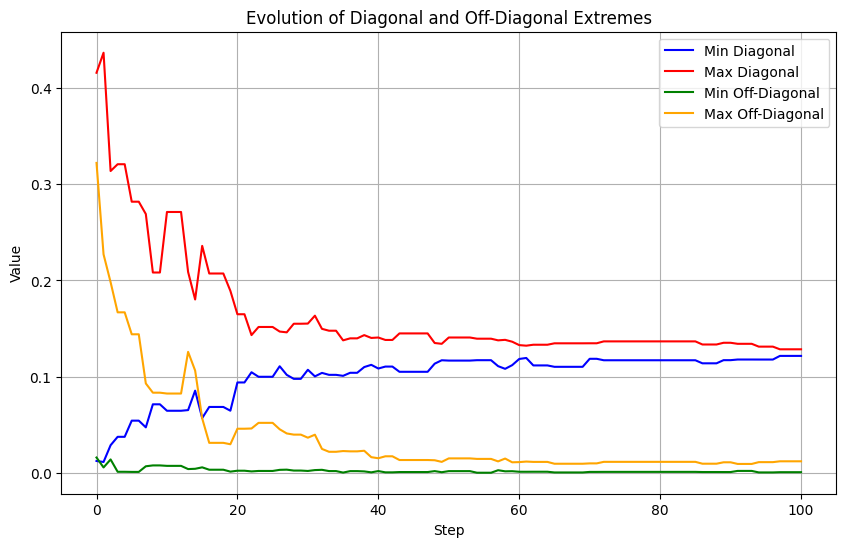

interactive(children=(IntSlider(value=0, description='Step'), Output()), _dom_classes=('widget-interact',))

In [2]:
# Set the print options for numpy arrays
np.set_printoptions(precision=2, suppress=True)

N = 12
steps = 100
# class GateMatrix(Enum):
#     SQRT_SWAP = 1
#     CNOT = 2
#     SWAP = 3
#     CZ = 4
#     FIXED_RANDOM = 5
#     DYNAMIC_RANDOM = 6
simulate_qubits_with_evolution(N, steps, GateMatrix.DYNAMIC_RANDOM)